In [1]:
!ls /keyakizaka_mining/model/fasttext/

keyakizaka_blog_nva.model
nogikeyaki_blog_nva.model
nogikeyaki_blog_nva.model.trainables.vectors_ngrams_lockf.npy
nogikeyaki_blog_nva.model.wv.vectors_ngrams.npy


In [71]:
# path

neologd_dict_path = '/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd'
font_path = "/usr/share/fonts/truetype/takao-gothic/TakaoGothic.ttf"
blog_save_dir = '/keyakizaka_mining/data/blog'
fasttext_model_save_dir = '/keyakizaka_mining/model/fasttext'

In [72]:
# library

import pandas as pd
import numpy as np
import seaborn as sns

from gensim.models import FastText
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture

In [73]:
# cloudpickle

import cloudpickle

def load_from_pkl( fpath ):
    frb = open(fpath, 'rb')
    obj = cloudpickle.loads(frb.read())
    return obj

def save_as_pkl( obj, fpath ):
    fwb = open( fpath, 'wb')
    tmp = fwb.write(cloudpickle.dumps(obj))
    return

In [74]:
# japanese NLP

import MeCab
mecab = MeCab.Tagger (r"-Ochasen -d %s" % neologd_dict_path)

import re, unicodedata
import neologdn

def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    return replaced_text

def normalize_text( text ):
    text = neologdn.normalize(text)
    text = normalize_number(text)    
    return text

def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text

def get_tokens_pos( text, target_pos ):
    tokens = []
    for line in mecab.parse( text ).split('\n')[:-2]:
        line = line.split('\t')
        pos = line[3].split('-')[0]
        if pos in target_pos: tokens.append( line[2] )
    return tokens

In [75]:
# functions for scdv
# ref ... https://qiita.com/fufufukakaka/items/a7316273908a7c400868

def cluster_GMM(num_clusters, word_vectors):
    clf =  GaussianMixture(n_components=num_clusters,
                           covariance_type="tied",
                           init_params='kmeans',
                           max_iter=50)
    
    clf.fit(word_vectors)
    idx = clf.predict(word_vectors)
    idx_proba = clf.predict_proba(word_vectors)
    
    return (idx, idx_proba)

def get_probability_word_vectors(featurenames, word_centroid_map, num_clusters, word_idf_dict):
    prob_wordvecs = {}
    for word in word_centroid_map:
        prob_wordvecs[word] = np.zeros( num_clusters * num_features, dtype="float32" )
        for c_idx in range(0, num_clusters):
            if not word in word_idf_dict: continue
            prob_wordvecs[word][c_idx*num_features:(c_idx+1)*num_features] = model.wv[word] * word_centroid_prob_map[word][c_idx] * word_idf_dict[word]
    return prob_wordvecs

def create_cluster_vector_and_gwbowv(prob_wordvecs, wordlist, word_centroid_map, word_centroid_prob_map, dimension, word_idf_dict, featurenames, num_centroids, train=False):
    bag_of_centroids = np.zeros( num_centroids * dimension, dtype="float32" )
    for word in wordlist:
        if not word in word_centroid_map: continue  
        bag_of_centroids += prob_wordvecs[word]

    norm = np.sqrt(np.einsum('...i,...i', bag_of_centroids, bag_of_centroids))
    if norm != 0: bag_of_centroids /= norm

    # To make feature vector sparse, make note of minimum and maximum values.
    global min_no
    global max_no
    if train:
        min_no += min(bag_of_centroids)
        max_no += max(bag_of_centroids)

    return bag_of_centroids

In [76]:
# japanese plot setting

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_prop = FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()

In [77]:
# scdv parameters

num_features = 100 # fastText embedding dim
num_clusters = 30 # cluster num of GMM clustering

In [78]:
# read text + tokenize

# 
sentences = load_from_pkl( '%s/keyakizaka_blog_nva_sentences.pkl' % (blog_save_dir) )
doc_num = len( sentences )

In [9]:
# load fastText

model = FastText.load('%s/keyakizaka_blog_nva.model' % fasttext_model_save_dir)

In [10]:
# apply GMM clustering to embedding vectors

word_vectors = model.wv.vectors
idx, idx_proba = cluster_GMM(num_clusters, word_vectors) # Set number of clusters.
word_centroid_map = dict(zip( model.wv.index2word, idx )) # { word : c_idx } # Create a Word / Index dictionary, mapping each vocabulary word to a cluster number
word_centroid_prob_map = dict(zip( model.wv.index2word, idx_proba )) # { word : [c_prob] } # Create a Word / Probability of cluster assignment dictionary, mapping each vocabulary word to list of probabilities of cluster assignments.

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [79]:
# Computing tf-idf values.

sentences_wakati = [ ' '.join(tokens) for tokens in sentences ]

tfv = TfidfVectorizer(dtype=np.float32)
tfidfmatrix_traindata = tfv.fit_transform(sentences_wakati)
featurenames = tfv.get_feature_names()
idf = tfv._tfidf.idf_

word_idf_dict = { pair[0]:pair[1] for pair in zip(featurenames, idf) }

In [29]:
# Pre-computing probability word-cluster vectors.

prob_wordvecs = get_probability_word_vectors(featurenames, word_centroid_map, num_clusters, word_idf_dict)

# get SCDV

min_no = 0
max_no = 0
X = np.zeros( (doc_num, num_clusters*(num_features)), dtype="float32")
for idx, tokens in enumerate( sentences ):
    X[idx] = create_cluster_vector_and_gwbowv(prob_wordvecs, tokens, word_centroid_map, word_centroid_prob_map, num_features, word_idf_dict, featurenames, num_clusters,
                                                   train=True)

# Set the threshold percentage for making it sparse. 

percentage = 0.04
min_no = min_no / float( doc_num )
max_no = max_no / float( doc_num )

# Make values of matrices which are less than threshold to zero.

thres = (abs(max_no) + abs(min_no)) / 2
thres = thres * percentage
temp = abs(X) < thres
X[temp] = 0

In [32]:
save_as_pkl( X, 'scdv_features.pkl' )

In [ ]:
# 可視化

In [90]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#pca = PCA(); pca.fit(X); X_r = pca.fit_transform( X )
X_r = TSNE(n_components=2, perplexity=20, random_state=0).fit_transform( X )

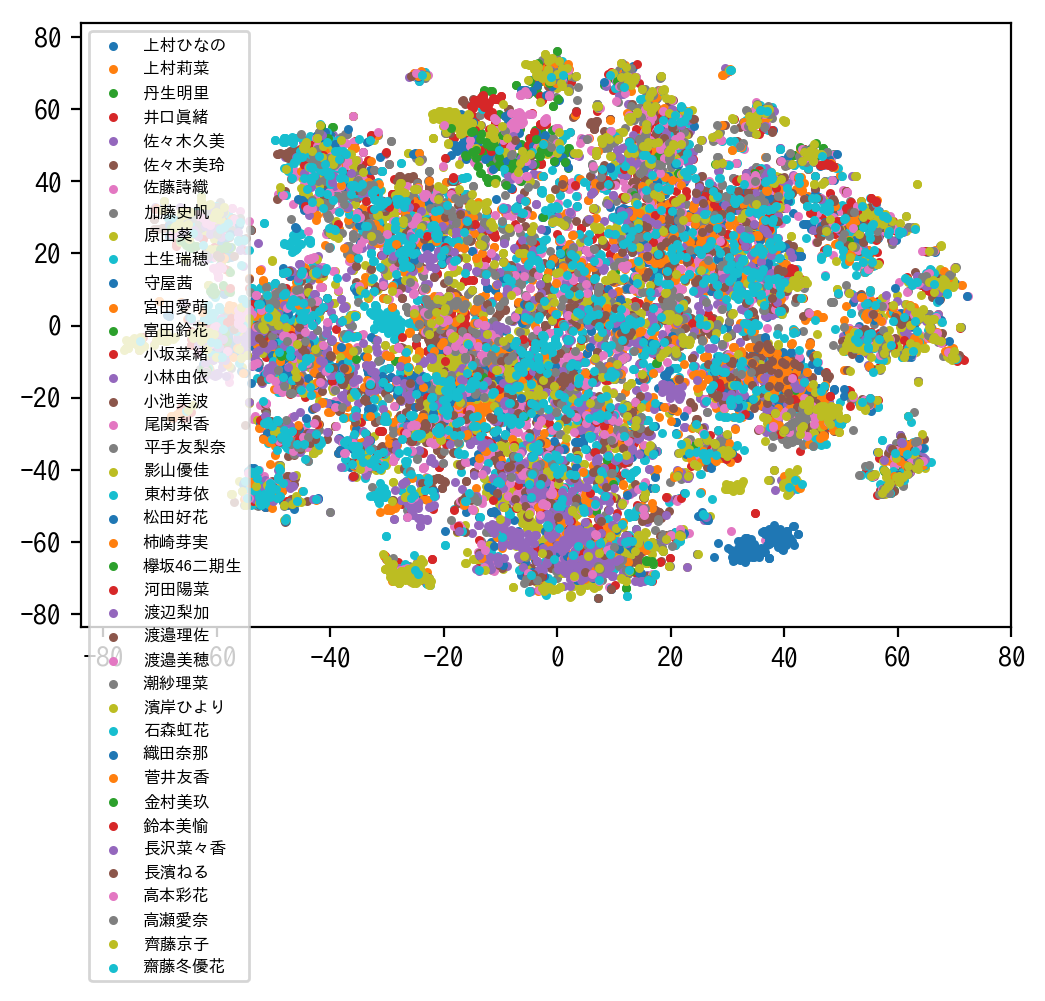

In [91]:
def get_groups( t_cluster ):
    groups_tmp = {}
    for i, l in enumerate( t_cluster ):
        if not l in groups_tmp: groups_tmp[l] = []
        groups_tmp[l].append( i )
    return groups_tmp

def plot( X_tmp, y_tmp, d1, d2 ):
    fig = plt.figure(figsize=(6,4),dpi=200)    

    groups = get_groups( y_tmp )
    for k, nodes in sorted( groups.items() ):
        plt.scatter(X_tmp[nodes, d1], X_tmp[nodes, d2], s=5, label=k) 

    plt.legend(prop={'size': 6})
    plt.show()

y = df['author'].values.tolist()
plot( X_r, y, 0, 1 )

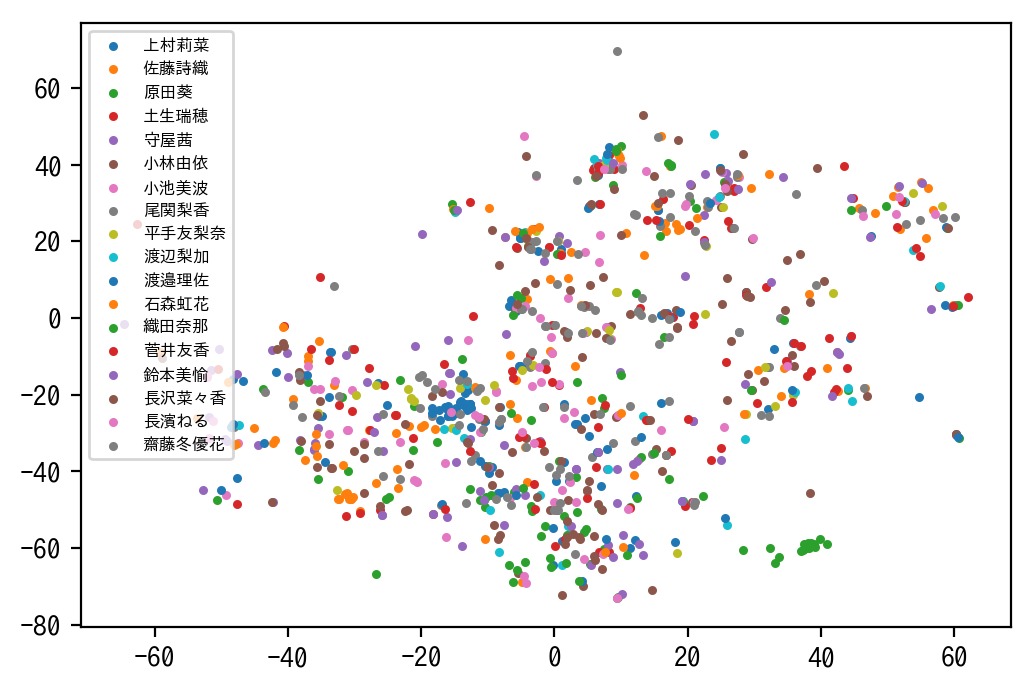

In [93]:
y = df['author'].values.tolist()
plot( X_r[:1000], y[:1000], 0, 1 )

In [ ]:
# 著者分類

In [95]:
!pip install lightgbm

    100% |████████████████████████████████| 1.2MB 25.3MB/s 


In [101]:
# ML
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

X = np.array(X)
y = df['author'].values

# learn (5-fold cv)

pred_tests = []
acc_score_cv = []

kf = StratifiedKFold(n_splits=5, random_state=777, shuffle=True)
for idx, (train, val) in enumerate( kf.split(X, y) ):
    print( "fold -", idx )
    
    # learn model
    # clf = RandomForestClassifier(n_estimators=10)
    clf = lgb.LGBMClassifier(n_estimators=10, objective="multiclass")
    clf.fit(X[train], y[train])
    
    # predict validation and score
    preds = clf.predict(X[val])
    acc_cv = accuracy_score( preds, y[val] )
    acc_score_cv.append( acc_cv )
    print( classification_report(y[val], preds) )
    
# cv score
print( acc_score_cv )
print( 'Mean:', sum( acc_score_cv ) / len( acc_score_cv ) )

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


fold - 0
              precision    recall  f1-score   support

       上村ひなの       0.00      0.00      0.00         1
        上村莉菜       0.79      0.80      0.80       107
        丹生明里       0.61      0.66      0.63        29
        井口眞緒       0.60      0.65      0.62       133
       佐々木久美       0.99      0.87      0.92        77
       佐々木美玲       0.88      0.94      0.91       108
        佐藤詩織       0.94      0.88      0.91       104
        加藤史帆       0.91      0.91      0.91       141
         原田葵       0.95      0.90      0.92       134
        土生瑞穂       0.57      0.45      0.50        93
         守屋茜       0.50      0.36      0.42       115
        宮田愛萌       0.91      0.94      0.93        33
        富田鈴花       0.44      0.50      0.47        22
        小坂菜緒       0.55      0.55      0.55        20
        小林由依       0.63      0.60      0.61        85
        小池美波       0.88      0.75      0.81       104
        尾関梨香       0.95      0.80      0.86       108
       平手友梨奈      

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

       上村ひなの       0.00      0.00      0.00         0
        上村莉菜       0.86      0.84      0.85       106
        丹生明里       0.69      0.64      0.67        28
        井口眞緒       0.63      0.62      0.63       132
       佐々木久美       0.97      0.91      0.94        76
       佐々木美玲       0.96      0.94      0.95       108
        佐藤詩織       0.88      0.89      0.89       104
        加藤史帆       0.90      0.92      0.91       141
         原田葵       0.92      0.84      0.88       133
        土生瑞穂       0.64      0.51      0.57        93
         守屋茜       0.55      0.47      0.51       115
        宮田愛萌       0.94      0.91      0.92        32
        富田鈴花       1.00      0.62      0.76        21
        小坂菜緒       0.89      0.40      0.55        20
        小林由依       0.74      0.61      0.67        84
        小池美波       0.87      0.86      0.86       104
        尾関梨香       0.89      0.76      0.82       107
       平手友梨奈       0.75    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

       上村ひなの       0.00      0.00      0.00         0
        上村莉菜       0.84      0.84      0.84       106
        丹生明里       0.76      0.68      0.72        28
        井口眞緒       0.59      0.67      0.63       132
       佐々木久美       0.99      0.92      0.95        76
       佐々木美玲       0.96      0.94      0.95       107
        佐藤詩織       0.83      0.85      0.84       103
        加藤史帆       0.89      0.89      0.89       140
         原田葵       0.95      0.92      0.93       133
        土生瑞穂       0.63      0.37      0.47        92
         守屋茜       0.51      0.37      0.43       115
        宮田愛萌       1.00      0.84      0.92        32
        富田鈴花       0.89      0.81      0.85        21
        小坂菜緒       0.59      0.68      0.63        19
        小林由依       0.70      0.45      0.55        84
        小池美波       0.90      0.85      0.88       103
        尾関梨香       0.91      0.72      0.80       107
       平手友梨奈       0.40    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [30]:
# 類似ブログ検索テスト

In [7]:
from annoy import AnnoyIndex

In [15]:
# read blog data

df = pd.read_csv( '%s/keyakizaka46_blog_20190217.csv' % (blog_save_dir) )
print( df.shape )
X = load_from_pkl( 'scdv_features.pkl' )
print( X.shape )

(16754, 6)
(16754, 3000)


In [26]:
titles = { idx: title for idx, title in enumerate( df['title'].values ) }
authors = { idx: author for idx, author in enumerate( df['author'].values ) }
texts = { idx: text for idx, text in enumerate( df['text'].values ) }

In [12]:
# annoy

doc_num = X.shape[0]
feature_dim = X.shape[1]

t = AnnoyIndex( feature_dim )
for i in range( doc_num ):
    t.add_item(i, X[:,:feature_dim][i])

t.build(10)
# t.save('test.ann')

True

In [84]:
target = 4378
k = 4
near_list, dists = t.get_nns_by_item(target, k, include_distances=True) # 

doc_idx = near_list[0]
text = texts[doc_idx].replace('\n','')
target_tokens = set( get_tokens_pos( text, ['名詞', '動詞', '形容詞'] ) )
print( 'Query blog' )
print( 'author:%s \ntitle:%s' % (authors[doc_idx], titles[doc_idx]) )
print( 'text:\n', text )
print()

for i in range( 1, k, 1 ): # search_k=-1
    doc_idx = near_list[i]
    text = texts[doc_idx].replace('\n','')
    tokens = set( get_tokens_pos( text, ['名詞', '動詞', '形容詞'] ) )
    print( 'Rank:%d - distance:%f' % ( i, dists[i]) )
    print( target_tokens & tokens )
    
    print()
    print( 'author:%s \ntitle:%s' % (authors[doc_idx], titles[doc_idx]) )
    print( 'text:\n', text )
    print()

Query blog
author:菅井友香 
title:@JAM×ナタリーEXPO 2016
text:
 こんばんは☆彡.。今日は幕張メッセにて開催された「@JAM×ナタリーEXPO 2016」に欅坂46が初出演させていただきました♪♪沢山のアーティストさんが出演されるこのステージに私たちも出演させていただき、とっても嬉しかったです!雨でお足元の悪い中お越しいただき、本当にありがとうございました♡今日は「サイレントマジョリティー」の歌衣装をライブで初めて披露しました♪いかがでしたか??みなさんにお見せ出来るのをずーっと楽しみにしてたんです♡渋谷のビルの風景がデザインされているんですよー♪衣装はよく見るとデザインが三種類あるんです!今までローファーで踊っていたので、スニーカーはとても新鮮でした!今日のライブでは、「手を繋いで帰ろうか」で花道を使ったパフォーマンスに初めて挑戦させていただきました!歌詞のストーリーを花道やセンターステージで再現しました!みなさんのお顔が間近で見られてとっても楽しかったです!これから、色々なライブで、みなさんにもっと楽しんでいただけるような工夫が出来るといいなと思います!なんだか今日は大きなステージにいつも以上にとても緊張してしまいました(><)MCでは思うように言葉が出てこなかったり、上手く伝えられなかったりと反省点が沢山、、、今後に繋げたいです。ゆいぽんとライブ後にパシャリ⌄̈⃝明日はトークステージに出演させていただきます!一生懸命頑張ってきますねー(•̀ω•́ )و!!応援よろしくお願い致します(/ω＼)それではまたね♡                                      ゆっかー

Rank:1 - distance:0.499698
{'サイレントマジョリティー', 'パフォーマンス', '嬉しい', 'する', 'ステージ', 'みなさん', 'ライブ', '帰る', 'ー', '出来る', '繋ぐ', 'ん', '私たち', '応援', '手', '今', 'よう', 'いただく', '頑張る', 'ω', 'ある', '楽しい', 'MC', '出演', '思う', 'しまう', 'いる', '披露', 'いただける', '今日', '沢山', '見る', '中', 'ユッカ', 'さん', '欅